In [1]:
import sys
sys.path.append("../SimCLR/")

import argparse
import os

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm

import utils
from model import Model

In [2]:
def train(net, data_loader, train_optimizer):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)
        # [2*B, D]
        out = torch.cat([out_1, out_2], dim=0)
        # [2*B, 2*B]
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
        mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
        # [2*B, 2*B-1]
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

        # compute loss
        pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        # [2*B]
        pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
        loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num

# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

In [3]:
# parser = argparse.ArgumentParser(description='Train SimCLR')
# parser.add_argument('--feature_dim', default=128, type=int, help='Feature dim for latent vector')
# parser.add_argument('--temperature', default=0.5, type=float, help='Temperature used in softmax')
# parser.add_argument('--k', default=200, type=int, help='Top k most similar images used to predict the label')
# parser.add_argument('--batch_size', default=512, type=int, help='Number of images in each mini-batch')
# parser.add_argument('--epochs', default=500, type=int, help='Number of sweeps over the dataset to train')

# args parse
# args = parser.parse_args()
# feature_dim, temperature, k = args.feature_dim, args.temperature, args.k
# batch_size, epochs = args.batch_size, args.epochs
feature_dim = 128
temperature = 0.5
k = 200
batch_size = 64
epochs = 1

In [10]:
feature = np.load("./notebooks/feature.npy")
y = np.load("./notebooks/all_label.npy")
# y = labels

In [43]:
from torchvision import transforms
class CellPair(list):
    """CIFAR10 Dataset.
    """
    def init(self, data, targets):
        self.data=data
        self.targets=targets
        self.num_samples = len(self.data)

#     def __getitem__(self, index):
#         img, target = self.data[index], self.targets[index]
#         img = Image.fromarray(img)

#         if self.transform is not None:
#             pos_1 = self.transform(img)
#             pos_2 = self.transform(img)

#         if self.target_transform is not None:
#             target = self.target_transform(target)

#         return pos_1, pos_2, target

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

In [44]:
dataset = []
for i in pairs:
    dataset += [torch.from_numpy(feature[i[0]]).reshape([64, 128,128]),
                torch.from_numpy(feature[i[1]]).reshape([64, 128,128]),
                y[i[0]]]

In [47]:
pairs = []
while True:
    a, b = np.random.randint(0, len(y), 2)
    if y[a] == y[b]:
        pairs.append([a,b])
    if len(pairs) == 200:
        break

In [48]:
# data prepare
train_data = utils.CIFAR10Pair(root='data', train=True, transform=utils.train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                          drop_last=True)
memory_data = utils.CIFAR10Pair(root='data', train=True, transform=utils.test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = utils.CIFAR10Pair(root='data', train=False, transform=utils.test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# model setup and optimizer config
model = Model(feature_dim).cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
c = len(memory_data.classes)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
# Model Params: 24.62M FLOPs: 1.31G


In [12]:
# training loop
results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temperature, k, batch_size, epochs)
if not os.path.exists('results'):
    os.mkdir('results')
best_acc = 0.0
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv('results/{}_statistics.csv'.format(save_name_pre), index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save(model.state_dict(), 'results/{}_model.pth'.format(save_name_pre))

Test Epoch: [1/1] Acc@1:44.51% Acc@5:91.64%: 100%|█████████████████████████████████| 157/157 [00:05<00:00, 26.41it/s]


In [14]:
train_loader

In [106]:
# net.train()
total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
for pos_1, pos_2, target in train_bar:
    pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)

NameError: name 'data_loader' is not defined

In [16]:
for a, b, c in tqdm(train_loader):
    print(a,b,c)


  0%|                                                                                        | 0/781 [00:00<?, ?it/s]/home/wd/miniconda3/envs/same/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

  1%|▌                                                                               | 5/781 [00:00<01:37,  7.93it/s]

tensor([[[[-1.1497e+00, -8.2012e-01, -4.5180e-01,  ..., -1.4404e+00,
           -1.3435e+00, -1.2660e+00],
          [-1.2466e+00, -9.9458e-01, -7.2319e-01,  ..., -1.4598e+00,
           -1.3241e+00, -1.2272e+00],
          [-1.1109e+00, -9.7520e-01, -8.0073e-01,  ..., -1.2466e+00,
           -1.0140e+00, -8.3950e-01],
          ...,
          [-2.9672e-01, -2.7734e-01, -2.5796e-01,  ..., -1.6103e-01,
           -3.1611e-01, -4.5180e-01],
          [-1.2226e-01, -2.1919e-01, -3.7426e-01,  ..., -1.8042e-01,
           -3.1611e-01, -4.7119e-01],
          [ 5.2204e-02, -1.6103e-01, -4.3242e-01,  ..., -3.1611e-01,
           -4.3242e-01, -5.6811e-01]],

         [[-1.3956e+00, -1.0612e+00, -7.0724e-01,  ..., -1.4152e+00,
           -1.3562e+00, -1.3169e+00],
          [-1.4349e+00, -1.1989e+00, -9.4324e-01,  ..., -1.5136e+00,
           -1.4152e+00, -1.3366e+00],
          [-1.2186e+00, -1.1006e+00, -9.4324e-01,  ..., -1.4152e+00,
           -1.1792e+00, -1.0022e+00],
          ...,
     


  2%|█▋                                                                             | 17/781 [00:01<00:28, 26.70it/s]

tensor([[[[ 0.9827,  0.9633,  0.9245,  ...,  0.5562,  0.6919,  0.7307],
          [ 0.9827,  0.9827,  0.9245,  ...,  0.5562,  0.6725,  0.7113],
          [ 0.9633,  0.9633,  0.9051,  ...,  0.5174,  0.6531,  0.6919],
          ...,
          [-0.1804, -0.1804, -0.1804,  ..., -0.5681, -0.5875, -0.5875],
          [-0.2580, -0.2580, -0.2386,  ..., -0.2967, -0.1804, -0.1416],
          [-0.2967, -0.2967, -0.2773,  ..., -0.1610,  0.0328,  0.0716]],

         [[ 1.0431,  1.0234,  0.9841,  ...,  0.6104,  0.7481,  0.7874],
          [ 1.0431,  1.0431,  0.9841,  ...,  0.6104,  0.7284,  0.7678],
          [ 1.0234,  1.0234,  0.9644,  ...,  0.5711,  0.7088,  0.7481],
          ...,
          [-0.1369, -0.1369, -0.1369,  ..., -0.5302, -0.5499, -0.5499],
          [-0.2156, -0.2156, -0.1959,  ..., -0.2549, -0.1369, -0.0976],
          [-0.2549, -0.2549, -0.2352,  ..., -0.1172,  0.0794,  0.1188]],

         [[ 1.2124,  1.1929,  1.1539,  ...,  0.7832,  0.9198,  0.9588],
          [ 1.2124,  1.2124,  


  3%|██▋                                                                            | 27/781 [00:01<00:21, 34.39it/s]

tensor([[[[-0.2580, -0.1610, -0.1416,  ..., -0.9170, -0.9364, -0.6457],
          [-0.5681, -0.2967, -0.2773,  ..., -0.8589, -0.9170, -0.7426],
          [-0.6844, -0.3743, -0.3355,  ..., -0.9170, -0.9364, -0.7813],
          ...,
          [-0.2580, -0.2580, -0.1998,  ...,  1.5448,  1.4867,  1.3510],
          [-0.1998, -0.1610, -0.1804,  ...,  1.2735,  1.2153,  1.0214],
          [ 0.2461,  0.2073,  0.1104,  ...,  1.1571,  1.0990,  1.0796]],

         [[ 0.2564,  0.4728,  0.5121,  ..., -0.4712, -0.3729, -0.0189],
          [-0.0386,  0.3154,  0.3941,  ..., -0.4122, -0.3926, -0.1369],
          [-0.1762,  0.2171,  0.2958,  ..., -0.4122, -0.4122, -0.2746],
          ...,
          [ 0.7481,  0.7874,  0.7874,  ...,  2.4198,  2.4395,  2.3215],
          [ 0.8661,  0.8661,  0.8661,  ...,  2.2625,  2.2231,  1.9675],
          [ 1.1414,  1.1021,  1.0628,  ...,  2.2625,  2.1641,  2.0658]],

         [[-0.1728, -0.1338, -0.1533,  ..., -0.7971, -0.9337, -0.7386],
          [-0.5240, -0.2704, -


  5%|███▋                                                                           | 37/781 [00:01<00:18, 41.03it/s]

tensor([[[[ 1.3510,  1.3510,  1.3704,  ...,  1.9132,  1.9325,  1.9325],
          [ 1.2928,  1.2928,  1.3122,  ...,  1.8744,  1.8938,  1.8744],
          [ 1.1765,  1.1765,  1.1959,  ...,  1.7968,  1.7775,  1.7581],
          ...,
          [-2.2546, -2.2546, -2.2740,  ..., -2.2740, -2.2546, -2.2546],
          [-2.2158, -2.2158, -2.2546,  ..., -2.2934, -2.2740, -2.2740],
          [-2.1964, -2.1964, -2.2352,  ..., -2.3128, -2.2934, -2.2934]],

         [[ 1.4364,  1.4364,  1.4364,  ...,  1.8495,  1.8691,  1.8691],
          [ 1.3774,  1.3774,  1.3774,  ...,  1.7708,  1.7708,  1.7708],
          [ 1.2594,  1.2594,  1.2594,  ...,  1.6134,  1.5348,  1.5151],
          ...,
          [-1.9463, -1.9463, -1.9463,  ..., -1.9463, -1.9266, -1.9266],
          [-1.9069, -1.9069, -1.9266,  ..., -1.9659, -1.9463, -1.9463],
          [-1.8873, -1.8873, -1.9266,  ..., -1.9659, -1.9463, -1.9463]],

         [[ 1.6026,  1.6026,  1.6026,  ...,  2.0319,  2.0123,  2.0123],
          [ 1.5441,  1.5441,  


  6%|████▊                                                                          | 48/781 [00:01<00:16, 44.31it/s]

tensor([[[[-2.3321, -2.3321, -2.2934,  ..., -2.0608, -2.1577, -2.0801],
          [-2.3321, -2.3321, -2.2352,  ..., -1.8863, -1.8863, -1.9251],
          [-2.3128, -2.3321, -2.1577,  ..., -1.9832, -2.0608, -2.0801],
          ...,
          [-2.3709, -2.3515, -2.3321,  ..., -0.4906, -0.6457, -1.3047],
          [-2.3709, -2.3321, -2.3321,  ..., -0.4712, -0.6069, -1.1497],
          [-2.3709, -2.3515, -2.3515,  ..., -0.4712, -0.6069, -1.1109]],

         [[-1.9856, -1.9266, -1.9463,  ..., -1.8282, -1.9069, -1.9069],
          [-1.9856, -1.9463, -1.9856,  ..., -1.6512, -1.6906, -1.7692],
          [-1.9659, -1.9463, -1.9069,  ..., -1.7102, -1.7299, -1.7889],
          ...,
          [-2.3396, -2.3199, -2.3003,  ..., -1.2382, -1.3562, -1.7692],
          [-2.3396, -2.3003, -2.3003,  ..., -1.1989, -1.2579, -1.6316],
          [-2.3396, -2.3199, -2.3199,  ..., -1.1596, -1.2382, -1.5922]],

         [[-1.6361, -1.5190, -1.5385,  ..., -1.5971, -1.6556, -1.5971],
          [-1.5971, -1.4800, -


  8%|██████                                                                         | 60/781 [00:01<00:15, 47.88it/s]

tensor([[[[-1.3823, -0.8589, -0.3936,  ...,  0.0522,  0.0716,  0.0910],
          [-1.8087, -1.3435, -0.8007,  ..., -0.0447, -0.0447, -0.0253],
          [-2.4291, -2.0995, -1.4404,  ..., -0.1998, -0.1998, -0.1998],
          ...,
          [-0.8977, -0.8783, -0.8007,  ..., -0.7620, -0.8201, -0.8977],
          [-0.7813, -0.8007, -0.7813,  ..., -0.7813, -0.7813, -0.8201],
          [-0.7426, -0.7620, -0.7813,  ..., -0.8201, -0.7813, -0.7813]],

         [[-1.4152, -0.8646, -0.3336,  ...,  0.1384,  0.1581,  0.1581],
          [-1.8282, -1.3366, -0.7466,  ...,  0.0598,  0.0598,  0.0598],
          [-2.4183, -2.0839, -1.4152,  ..., -0.0582, -0.0189, -0.0189],
          ...,
          [-0.8646, -0.8646, -0.7859,  ..., -0.7662, -0.8252, -0.8842],
          [-0.7859, -0.7859, -0.7859,  ..., -0.7859, -0.7859, -0.8252],
          [-0.7269, -0.7466, -0.7859,  ..., -0.8252, -0.7859, -0.7859]],

         [[-1.3044, -0.7191, -0.1338,  ...,  0.5296,  0.5296,  0.5296],
          [-1.6946, -1.1873, -


  8%|██████▌                                                                        | 65/781 [00:02<00:16, 44.23it/s]

tensor([[[[ 7.6945e-01,  3.2359e-01,  5.2204e-02,  ...,  1.1378e+00,
            1.2347e+00,  1.3316e+00],
          [ 8.6637e-01,  7.1129e-01,  6.5314e-01,  ...,  9.2452e-01,
            1.0990e+00,  1.2735e+00],
          [ 5.1744e-01,  6.1437e-01,  8.4699e-01,  ...,  7.5006e-01,
            1.0021e+00,  1.2541e+00],
          ...,
          [ 1.7775e+00,  1.5255e+00,  8.8576e-01,  ...,  1.8162e+00,
            1.8162e+00,  1.8162e+00],
          [ 1.6030e+00,  1.3122e+00,  6.9191e-01,  ...,  1.8162e+00,
            1.8162e+00,  1.8162e+00],
          [ 1.3316e+00,  1.1378e+00,  7.1129e-01,  ...,  1.8162e+00,
            1.8162e+00,  1.8162e+00]],

         [[-6.4824e-01, -1.0809e+00, -1.2972e+00,  ..., -3.9257e-01,
           -2.5490e-01, -9.7567e-02],
          [-6.0891e-01, -7.2691e-01, -7.6624e-01,  ..., -6.2857e-01,
           -3.9257e-01, -1.3690e-01],
          [-9.4324e-01, -8.4491e-01, -6.8757e-01,  ..., -7.8591e-01,
           -4.5157e-01, -1.7623e-01],
          ...,
     


 10%|███████▌                                                                       | 75/781 [00:02<00:16, 42.15it/s]

tensor([[[[-0.4712, -0.5487, -0.6457,  ..., -1.7118, -1.5955, -1.4986],
          [-0.6069, -0.6650, -0.7232,  ..., -1.7312, -1.6924, -1.5761],
          [-0.8395, -0.8977, -0.9170,  ..., -1.7700, -1.7700, -1.7700],
          ...,
          [-0.9558, -1.0915, -1.2660,  ..., -1.1690, -1.0527, -0.9752],
          [-1.2078, -1.2466, -1.3435,  ..., -1.3047, -1.1497, -1.0334],
          [-1.3435, -1.3629, -1.3823,  ..., -1.3629, -1.1884, -1.0334]],

         [[-0.3926, -0.4712, -0.5302,  ..., -1.5529, -1.4939, -1.3562],
          [-0.5302, -0.5892, -0.6286,  ..., -1.5922, -1.5529, -1.4546],
          [-0.7466, -0.7859, -0.8252,  ..., -1.6512, -1.6709, -1.6709],
          ...,
          [-0.8646, -0.9826, -1.1399,  ..., -1.0416, -0.9432, -0.8842],
          [-1.1006, -1.1399, -1.1989,  ..., -1.1596, -1.0416, -0.9236],
          [-1.2382, -1.2382, -1.2579,  ..., -1.2382, -1.0809, -0.9236]],

         [[ 0.0028, -0.1533, -0.3094,  ..., -1.4995, -1.3629, -1.2069],
          [-0.2118, -0.3289, -


 11%|████████▍                                                                      | 84/781 [00:02<00:19, 36.41it/s]

tensor([[[[-4.4721e-02, -4.4721e-02, -2.5336e-02,  ..., -1.2226e-01,
           -1.2226e-01, -1.2226e-01],
          [-1.2226e-01, -1.2226e-01, -1.2226e-01,  ..., -2.1919e-01,
           -1.9980e-01, -1.9980e-01],
          [-2.1919e-01, -2.1919e-01, -2.1919e-01,  ..., -2.5796e-01,
           -2.5796e-01, -3.1611e-01],
          ...,
          [-8.3950e-01, -5.2934e-01, -6.4106e-02,  ..., -5.9512e-03,
           -4.4721e-02, -6.4106e-02],
          [-1.5955e+00, -1.0915e+00, -4.1303e-01,  ...,  2.0728e-01,
            1.8790e-01,  1.6851e-01],
          [-1.8863e+00, -1.3629e+00, -6.8442e-01,  ...,  4.7867e-01,
            4.9806e-01,  4.7867e-01]],

         [[-5.1057e-01, -5.1057e-01, -4.9090e-01,  ..., -7.6624e-01,
           -7.4657e-01, -7.4657e-01],
          [-5.8924e-01, -5.8924e-01, -5.8924e-01,  ..., -8.0557e-01,
           -7.8591e-01, -7.8591e-01],
          [-6.6791e-01, -6.6791e-01, -6.4824e-01,  ..., -8.4491e-01,
           -8.4491e-01, -8.4491e-01],
          ...,
     


 11%|████████▉                                                                      | 88/781 [00:02<00:19, 35.57it/s]

tensor([[[[-1.1690e+00, -1.1690e+00, -1.1690e+00,  ...,  8.0822e-01,
            4.0113e-01,  1.6851e-01],
          [-1.1884e+00, -1.2078e+00, -1.2078e+00,  ...,  8.2760e-01,
            4.5929e-01,  2.2667e-01],
          [-1.2466e+00, -1.2660e+00, -1.2660e+00,  ...,  8.6637e-01,
            5.3683e-01,  3.4298e-01],
          ...,
          [-4.5180e-01, -4.3242e-01, -3.9365e-01,  ..., -6.2627e-01,
           -1.6103e-01,  1.2974e-01],
          [-5.2934e-01, -5.0996e-01, -4.5180e-01,  ..., -7.0381e-01,
           -3.3549e-01, -1.2226e-01],
          [-5.6811e-01, -5.4873e-01, -4.9057e-01,  ..., -7.4258e-01,
           -4.5180e-01, -2.7734e-01]],

         [[-1.3366e+00, -1.3169e+00, -1.2776e+00,  ...,  1.0038e+00,
            5.7111e-01,  3.1544e-01],
          [-1.3562e+00, -1.3562e+00, -1.3169e+00,  ...,  1.0234e+00,
            6.3011e-01,  3.7444e-01],
          [-1.4152e+00, -1.4152e+00, -1.3759e+00,  ...,  1.0628e+00,
            7.0877e-01,  4.9244e-01],
          ...,
     


 12%|█████████▋                                                                     | 96/781 [00:02<00:19, 35.76it/s]

tensor([[[[ 2.3009,  2.3009,  2.3009,  ...,  2.3009,  2.3009,  2.3009],
          [ 2.3009,  2.3009,  2.3009,  ...,  2.3009,  2.3009,  2.3009],
          [ 2.3009,  2.3009,  2.3009,  ...,  2.3009,  2.3009,  2.3009],
          ...,
          [-1.0721, -1.1303, -1.1884,  ..., -1.3435, -1.5567, -1.6343],
          [-1.3241, -1.3047, -1.2854,  ..., -1.1884, -1.3823, -1.4792],
          [-1.4598, -1.4404, -1.3629,  ..., -0.7038, -0.8201, -0.8977]],

         [[ 2.3805,  2.3805,  2.3805,  ...,  2.3805,  2.3805,  2.3805],
          [ 2.3805,  2.3805,  2.3805,  ...,  2.3805,  2.3805,  2.3805],
          [ 2.3608,  2.3608,  2.3608,  ...,  2.3805,  2.3805,  2.3805],
          ...,
          [-1.0612, -1.0809, -1.1596,  ..., -1.2382, -1.4546, -1.5332],
          [-1.2776, -1.2579, -1.2382,  ..., -1.0809, -1.2776, -1.3366],
          [-1.3956, -1.3956, -1.3169,  ..., -0.5696, -0.6482, -0.7466]],

         [[ 2.5391,  2.5391,  2.5391,  ...,  2.5391,  2.5391,  2.5391],
          [ 2.5391,  2.5391,  


 14%|██████████▌                                                                   | 106/781 [00:03<00:16, 42.13it/s]

tensor([[[[ 1.3704e+00,  1.5448e+00,  1.6418e+00,  ...,  5.1744e-01,
            1.0021e+00,  1.5642e+00],
          [ 1.4091e+00,  1.5642e+00,  1.6418e+00,  ...,  5.5621e-01,
            1.0408e+00,  1.6030e+00],
          [ 1.4091e+00,  1.5642e+00,  1.6418e+00,  ...,  5.5621e-01,
            1.0602e+00,  1.6418e+00],
          ...,
          [-2.3857e-01, -1.4165e-01, -4.4721e-02,  ...,  7.6945e-01,
            1.7387e+00,  2.3590e+00],
          [-1.9980e-01, -1.2226e-01,  3.2819e-02,  ...,  8.4699e-01,
            1.7775e+00,  2.3202e+00],
          [-6.4106e-02,  1.3434e-02,  9.0974e-02,  ...,  9.2452e-01,
            1.8162e+00,  2.2815e+00]],

         [[ 1.4364e+00,  1.6134e+00,  1.7118e+00,  ...,  5.7111e-01,
            1.0628e+00,  1.6331e+00],
          [ 1.4758e+00,  1.6331e+00,  1.7118e+00,  ...,  6.1044e-01,
            1.1021e+00,  1.6724e+00],
          [ 1.4758e+00,  1.6331e+00,  1.7118e+00,  ...,  6.1044e-01,
            1.1218e+00,  1.7118e+00],
          ...,
     


 15%|███████████▋                                                                  | 117/781 [00:03<00:14, 44.65it/s]

tensor([[[[ 1.9907e+00,  1.9907e+00,  1.9907e+00,  ...,  1.2928e+00,
            1.3704e+00,  1.4091e+00],
          [ 1.8550e+00,  1.8550e+00,  1.8356e+00,  ...,  1.1959e+00,
            1.2153e+00,  1.2735e+00],
          [ 1.0214e+00,  1.0214e+00,  1.0021e+00,  ...,  9.2452e-01,
            9.2452e-01,  9.6329e-01],
          ...,
          [ 2.2667e-01,  2.2667e-01,  2.4605e-01,  ..., -8.3491e-02,
           -1.4165e-01, -1.6103e-01],
          [-4.4721e-02,  1.3434e-02,  3.2819e-02,  ..., -1.4165e-01,
           -1.8042e-01, -1.8042e-01],
          [-1.8042e-01, -1.4165e-01, -6.4106e-02,  ..., -1.6103e-01,
           -1.8042e-01, -2.1919e-01]],

         [[ 2.0658e+00,  2.0658e+00,  2.0658e+00,  ...,  1.3774e+00,
            1.4561e+00,  1.4758e+00],
          [ 1.9675e+00,  1.9675e+00,  1.9478e+00,  ...,  1.2594e+00,
            1.2988e+00,  1.3381e+00],
          [ 1.1414e+00,  1.1414e+00,  1.1414e+00,  ...,  1.0038e+00,
            1.0431e+00,  1.0628e+00],
          ...,
     


 16%|████████████▊                                                                 | 128/781 [00:03<00:14, 46.36it/s]

tensor([[[[ 1.2735,  1.2735,  1.2928,  ...,  1.2928,  1.2928,  1.2928],
          [ 1.2928,  1.2928,  1.3122,  ...,  1.3122,  1.3122,  1.3122],
          [ 1.2928,  1.2928,  1.3122,  ...,  1.3122,  1.3122,  1.3122],
          ...,
          [ 0.2267, -0.1416, -0.5681,  ..., -0.8589, -0.6844, -0.5100],
          [-0.4324, -0.6844, -0.9170,  ..., -0.9558, -0.8977, -0.8589],
          [-0.6069, -0.7232, -0.8007,  ..., -1.0527, -1.0334, -1.0334]],

         [[ 1.3381,  1.3381,  1.3578,  ...,  1.3578,  1.3578,  1.3578],
          [ 1.3578,  1.3578,  1.3774,  ...,  1.3774,  1.3774,  1.3774],
          [ 1.3578,  1.3578,  1.3774,  ...,  1.3774,  1.3774,  1.3774],
          ...,
          [ 0.2761, -0.0976, -0.5302,  ..., -0.8252, -0.6482, -0.4712],
          [-0.3926, -0.6482, -0.8842,  ..., -0.9236, -0.8646, -0.8252],
          [-0.5696, -0.6876, -0.7662,  ..., -1.0219, -1.0022, -1.0022]],

         [[ 1.5051,  1.5051,  1.5246,  ...,  1.5246,  1.5246,  1.5246],
          [ 1.5246,  1.5246,  


 18%|█████████████▊                                                                | 138/781 [00:03<00:14, 45.25it/s]

tensor([[[[-0.2192, -0.2386, -0.2967,  ..., -1.1690, -0.8201, -0.6263],
          [-0.2386, -0.2967, -0.4712,  ..., -1.1690, -0.8007, -0.5487],
          [-0.3161, -0.4712, -0.6844,  ..., -1.1884, -0.7620, -0.4712],
          ...,
          [-0.3161, -0.2967, -0.3355,  ..., -0.8201, -0.4906, -0.3161],
          [-0.1223, -0.1416, -0.1610,  ..., -0.8007, -0.4906, -0.3161],
          [-0.0253, -0.0253, -0.0253,  ..., -0.8007, -0.4906, -0.3355]],

         [[-0.5106, -0.5302, -0.5696,  ..., -1.5332, -1.1989, -1.0022],
          [-0.4909, -0.5892, -0.7466,  ..., -1.5136, -1.1596, -0.9826],
          [-0.5696, -0.7072, -0.9432,  ..., -1.4349, -1.1596, -1.0022],
          ...,
          [-0.2352, -0.2549, -0.2746,  ..., -0.9629, -0.8056, -0.7072],
          [-0.0976, -0.1172, -0.1172,  ..., -0.9629, -0.8252, -0.7072],
          [-0.0779, -0.0779, -0.0779,  ..., -0.9629, -0.8252, -0.7662]],

         [[-0.4264, -0.5045, -0.6606,  ..., -2.1043, -1.7922, -1.6166],
          [-0.5045, -0.6411, -

 18%|█████████████▊                                                                | 138/781 [00:03<00:18, 35.47it/s]


KeyboardInterrupt: 

In [53]:
c

tensor([5, 3, 1, 4, 4, 3, 7, 9, 3, 0, 8, 0, 3, 1, 3, 2, 9, 1, 6, 9, 9, 9, 3, 2,
        9, 8, 9, 5, 8, 6, 9, 6, 4, 8, 3, 7, 9, 3, 5, 7, 3, 1, 3, 8, 5, 0, 5, 3,
        0, 3, 5, 9, 3, 6, 6, 4, 1, 4, 9, 0, 8, 2, 9, 8])

In [54]:
a.shape

torch.Size([64, 3, 32, 32])

In [55]:
b.shape

torch.Size([64, 3, 32, 32])

In [35]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


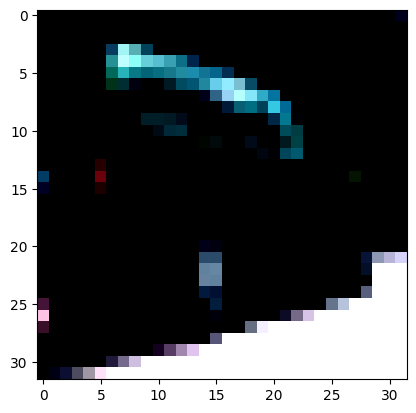

In [61]:
data = np.moveaxis(a[2].numpy(),0,-1)
plt.imshow(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


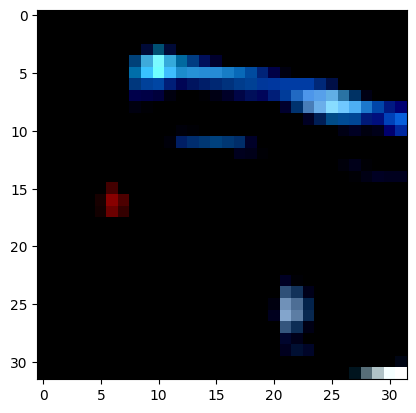

In [62]:
data = np.moveaxis(b[2].numpy(),0,-1)
plt.imshow(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


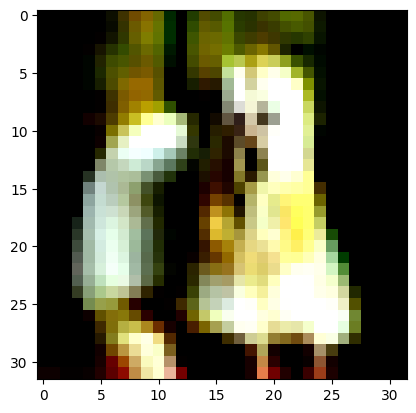

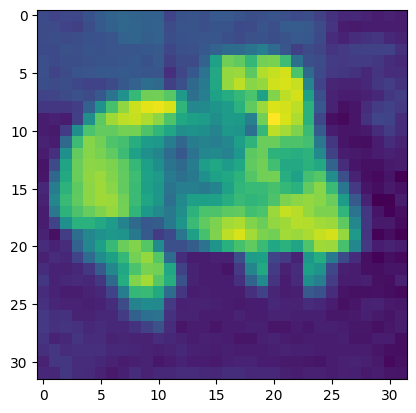

In [27]:
plt.imshow(b[0,2])

In [20]:
c.shape

torch.Size([64])